# Gene constraint pLI analysis

In [35]:
library(data.table)
library(tidyverse)
library(ggsignif)

**Read genomAD ExAC gene constraint**
- info for 18225 unique genes, some have alternative cnv related info

In [2]:
exac <- fread("/u/project/gandalm/shared/refGenomes/gnomAD_ExAC/forweb_cleaned_exac_r03_march16_z_data_pLI_CNV-final.txt.gz", 
              data.table = F)
head(exac)

,transcript,gene,chr,n_exons,tx_start,tx_end,bp,mu_syn,mu_mis,mu_lof,...,exp_syn,exp_mis,exp_lof,syn_z,mis_z,lof_z,pLI,n_cnv,exp_cnv,cnv_z
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENST00000263100.3,A1BG,19,8,58858387,58864803,1488,1.226238e-05,2.313709e-05,1.001499e-06,...,104.72874,199.8078,12.301382,1.07397341,1.0314310,1.2148449,9.064924e-05,3,3.609902,0.1114399
2,ENST00000373995.3,A1CF,10,11,52566488,52610547,1785,6.398919e-06,1.544409e-05,1.898738e-06,...,76.69884,178.5860,25.936584,-0.65840371,0.3874580,3.2942701,3.619701e-03,NaN,NaN,NaN
3,ENST00000318602.7,A2M,12,36,9220418,9268445,4425,1.762405e-05,4.048718e-05,3.983987e-06,...,187.60270,414.5167,51.706092,0.02727917,0.5169173,4.9188223,5.401149e-04,3,8.706319,0.8335034
4,ENST00000299698.7,A2ML1,12,35,8975247,9027607,4365,1.787013e-05,4.015104e-05,3.712316e-06,...,216.07566,467.0402,56.064599,-0.41854908,-0.7912401,1.8606843,1.329022e-22,63,11.846831,-2.2814308
5,ENST00000442999.3,A3GALT2,1,5,33772366,33786699,1023,1.013949e-05,1.867596e-05,7.352112e-07,...,83.27799,153.7933,8.016677,2.32862595,1.9638967,-0.3440241,6.503026e-07,70,2.768617,-3.6581477
6,ENST00000401850.1,A4GALT,22,1,43088895,43089957,1062,8.501714e-06,1.641234e-05,3.955250e-07,...,96.74529,186.3743,4.900477,0.61422759,1.1240807,1.2978961,1.115987e-01,2,1.082622,-0.2080141


In [3]:
dim(exac)
length(unique(exac$transcript))
length(unique(exac$gene))

[1] 18282    23

[1] 18225

[1] 18225

In [49]:
head(exac[duplicated(exac$gene),])

,transcript,gene,chr,n_exons,tx_start,tx_end,bp,mu_syn,mu_mis,mu_lof,...,exp_syn,exp_mis,exp_lof,syn_z,mis_z,lof_z,pLI,n_cnv,exp_cnv,cnv_z
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
177,ENST00000290866.4,ACE,17,25,61554455,61574727,3921,2.505688e-05,4.879264e-05,3.489547e-06,...,255.36203,497.51069,46.684991,-1.0722052,-1.0633131,1.8390400,4.632829e-18,6,7.560355,0.20763479
581,ENST00000531154.1,ALG9,11,11,111657120,111731321,1344,4.546618e-06,1.138693e-05,1.275424e-06,...,55.10152,131.13853,18.647516,0.4260566,0.8174463,2.4424601,1.225309e-03,4,5.889465,0.29371505
888,ENST00000311813.4,AQP1,7,4,30951524,30963244,810,5.831033e-06,1.091759e-05,4.713438e-07,...,66.54603,122.94933,6.891873,0.1934870,1.1887784,1.4685195,4.992564e-02,5,8.088807,0.41948559
2911,ENST00000287202.5,CELF6,15,12,72579605,72612215,1446,1.255576e-05,2.172531e-05,1.187156e-06,...,84.98649,153.14966,13.164702,2.3527451,2.8121043,2.7751012,3.768070e-01,1,4.305782,0.65904281
2986,ENST00000425368.2,CFB,6,18,31913998,31919807,2295,9.891069e-06,2.360029e-05,2.092371e-06,...,119.61161,274.93988,31.250734,1.5084600,2.2106026,3.5883955,9.788594e-04,11,11.669355,0.06529796
3611,ENST00000330233.7,CRIP1,14,4,105953596,105954848,234,1.549716e-06,2.862700e-06,2.372462e-07,...,17.04347,29.48948,3.562405,0.9075212,-0.5864063,-0.2296625,1.357960e-03,3,3.492841,0.09078386


In [44]:
exac %>% filter(gene == "CFB")

transcript,gene,chr,n_exons,tx_start,tx_end,bp,mu_syn,mu_mis,mu_lof,...,exp_syn,exp_mis,exp_lof,syn_z,mis_z,lof_z,pLI,n_cnv,exp_cnv,cnv_z
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENST00000425368.2,CFB,6,18,31913998,31919807,2295,9.891069e-06,2.360029e-05,2.092371e-06,...,119.6116,274.9399,31.25073,1.50846,2.210603,3.588395,0.0009788594,11,11.76966,0.07486886
ENST00000425368.2,CFB,6,18,31913998,31919807,2295,9.891069e-06,2.360029e-05,2.092371e-06,...,119.6116,274.9399,31.25073,1.50846,2.210603,3.588395,0.0009788594,11,11.66936,0.06529796


In [4]:
# duplicated gene entries differ in cnv related columns
exac <- exac %>% select(gene, pLI)
length(unique(exac$gene))

[1] 18225

In [5]:
exac <- exac[!duplicated(exac$gene),]

**Read data genes**

In [6]:
fetal <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/all_assoc_perm_info.txt", 
               data.table = F)
head(fetal)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,gene_type,gene_name
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05,protein_coding,DPM1
2,ENSG00000000457,7094,1.04721,695.715,467.037,rs761499672,-797092,4.58351e-05,0.174268,0.07059290,7.57180e-02,8.87792e-02,6.25971e-05,protein_coding,SCYL3
3,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05,protein_coding,C1orf112
4,ENSG00000000938,4365,1.01977,476.482,465.432,rs74060542,-40678,3.55489e-04,0.328784,0.31717400,3.13974e-01,2.30595e-01,8.28194e-05,protein_coding,FGR
5,ENSG00000000971,4671,1.02585,532.868,474.412,rs113887390,-792723,6.47444e-04,0.455490,0.48171300,4.74379e-01,2.93544e-01,7.57214e-05,protein_coding,CFH
6,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05,protein_coding,FUCA2


In [7]:
length(unique(fetal$gene_name))
length(unique(fetal$pid))

[1] 30993

[1] 31531

In [8]:
fetal <- fetal %>% mutate(sig = ifelse(fetal$qval < 0.05, "eGene", "non-eGene"))

In [19]:
table(fetal$sig)


    eGene non-eGene 
    10094     21437 

In [9]:
# remove duplicated gene names (Y_RNA, U3, etc.)
# or will have genes with the same name but in both sig and non-sig
dup_name <- unique(fetal[duplicated(fetal$gene_name),'gene_name'])
length(dup_name)

[1] 193

In [10]:
fetal2 <- fetal %>% filter(!gene_name %in% dup_name)
length(unique(fetal2$pid))
length(unique(fetal2$gene_name))
dim(fetal2)

[1] 30800

[1] 30800

[1] 30800    16

In [11]:
table(fetal2$sig)


    eGene non-eGene 
     9977     20823 

In [12]:
fetal2 <- fetal2 %>% left_join(exac, by = c("gene_name" = "gene"))

In [13]:
sum(complete.cases(fetal2$pLI))

[1] 14264

In [14]:
fetal3 <- fetal2 %>% select(pid, sig, gene_name, pLI)
head(fetal3)

,pid,sig,gene_name,pLI
,<chr>,<chr>,<chr>,<dbl>
1,ENSG00000000419,eGene,DPM1,5.367475e-01
2,ENSG00000000457,non-eGene,SCYL3,5.470538e-01
3,ENSG00000000460,eGene,C1orf112,5.981510e-08
4,ENSG00000000938,non-eGene,FGR,1.771744e-01
5,ENSG00000000971,non-eGene,CFH,9.996310e-01
6,ENSG00000001036,eGene,FUCA2,3.655835e-04


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”
Warning message:
“Removed 16536 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_signif).”


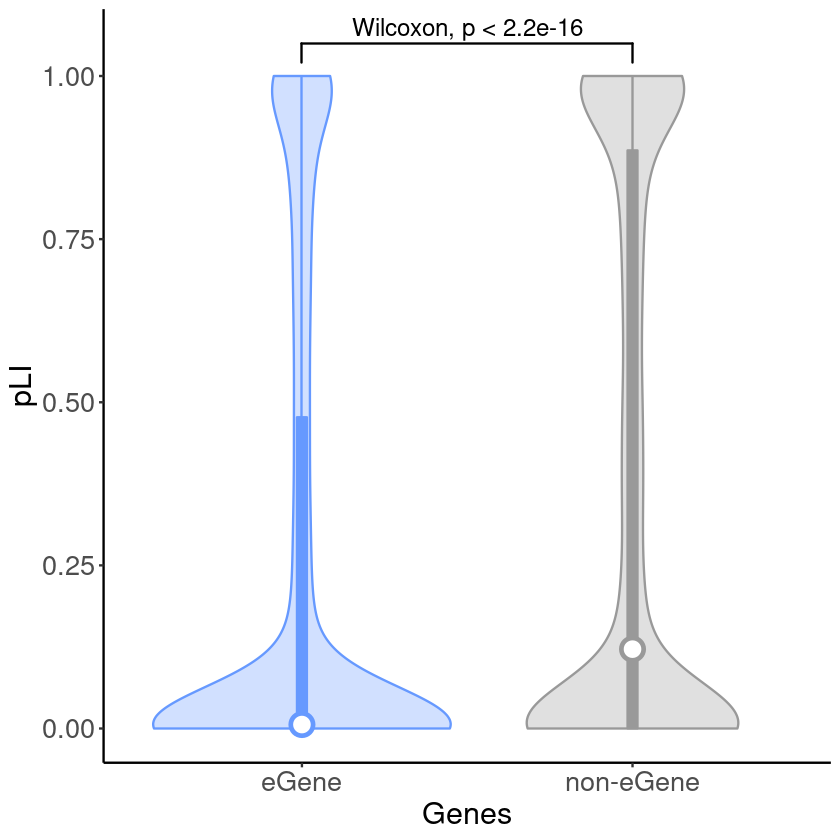

In [42]:
# modified boxplot, see ExAC original paper
p <- ggplot(fetal3, aes(x = sig, y = pLI, fill = sig)) +
    geom_violin(alpha = 0.3, trim = TRUE, aes(color = sig)) +
    geom_boxplot(width = 0.03, aes(color = sig)) +
    labs(x = "Genes", y = "pLI") + 
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.position = "none") +
    scale_fill_manual(values = c("#6699FF", "#999999")) +
    scale_color_manual(values = c("#6699FF", "#999999")) +
    stat_summary(fun.y = median, aes(color = sig), geom = "point", 
                         shape = 21, size = 5, show_guide = FALSE, fill = "white", stroke = 1.5) +
    geom_signif(
        comparisons = list(c("eGene", "non-eGene")),
        annotation = "Wilcoxon, p < 2.2e-16",
        textsize = 5
  )

p

In [43]:
ggsave("../figures/pLI.pdf", width = 6, height = 6)

Warning message:
“Removed 16536 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_signif).”


In [76]:
max(fetal2$pLI, na.rm = TRUE)

[1] 1

In [46]:
wilcox.test(fetal3[fetal3$sig == "eGene",'pLI'], fetal3[fetal3$sig == "non-eGene",'pLI'], alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  fetal3[fetal3$sig == "eGene", "pLI"] and fetal3[fetal3$sig == "non-eGene", "pLI"]
W = 19497180, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [47]:
wilcox.test(fetal3[fetal3$sig == "eGene",'pLI'], fetal3[fetal3$sig == "non-eGene",'pLI'])


	Wilcoxon rank sum test with continuity correction

data:  fetal3[fetal3$sig == "eGene", "pLI"] and fetal3[fetal3$sig == "non-eGene", "pLI"]
W = 19497180, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [ ]:
library(ggpubr)

Warning message:
“Removed 16536 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 16536 rows containing non-finite values (stat_compare_means).”


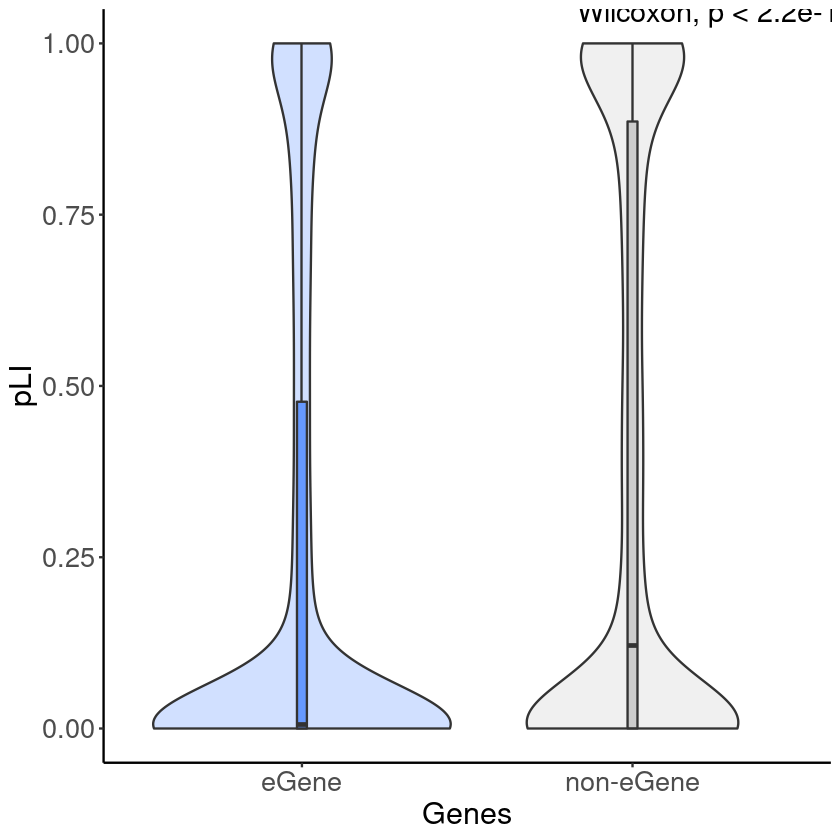

In [57]:
p + stat_compare_means(vjust = -1, bracket.size = 2, size = 6, label.x = "non-eGene")